In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from pandas.tseries.offsets import BDay


In [3]:
data = pd.read_csv("clean_data.csv")
data.sort_values("date", inplace=True)
data['date'] = pd.to_datetime(data['date'])

data.head(5)

,date,spy_close,spy_adjClose,spy_divCash,spy_diff,tlt_close,tlt_adjClose,tlt_divCash,tlt_diff
0,2002-07-26,85.599998,55.824445,0.0,29.775553,82.51,37.841243,0.0,44.668757
1,2002-07-29,89.769997,58.543930,0.0,31.226067,81.42,37.341341,0.0,44.078659
2,2002-07-30,90.940002,59.306954,0.0,31.633048,81.52,37.387203,0.0,44.132797
3,2002-07-31,91.160004,59.450430,0.0,31.709574,82.53,37.850416,0.0,44.679584
4,2002-08-01,88.779999,57.898298,0.0,30.881701,83.00,38.065970,0.0,44.934030


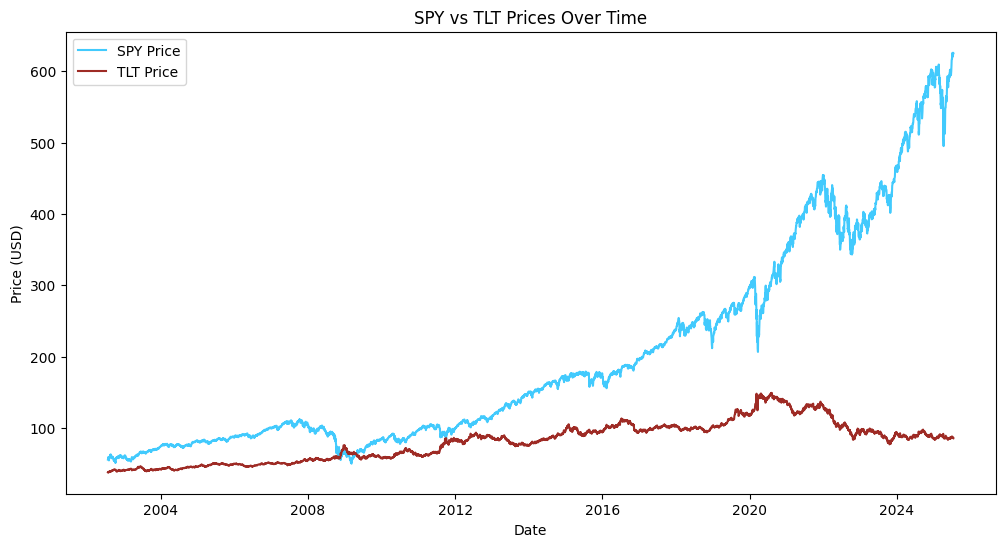

In [12]:
# Plot the historical data and check the trend
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['spy_adjClose'], label='SPY Price', color='#42CAFD')
plt.plot(data['date'], data['tlt_adjClose'], label='TLT Price', color='#9E2B25')
plt.title('SPY vs TLT Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

By analyzing the dataset, we can see both spy and tlt prices are increasing overtime in general. There were several small stock market drops. It would be beneficial to get as much data as possible to get a better understanding. Unfortunately, I could only get the history of the bond data from 2002. I will keep using this dataset and work on the project.

The combined dataset has spy (stock) and tlt (bond) history of 24 years on business days trading. Assume the inflation rate is 3% every year. 
I will build a simulation model first and then test various combinations of stock/bond ratios: 100/0, 75/25. 50/50, 25/75, 0/100, at different withdrawal rate: 3%, 4%, 5%, 6%. At each year, I will withdraw a fixed % of the initial portfolio value, and then deduct the withdrawal, apply the return for that year based on weighted stock/bond mix. Repeat for next year, until portfolio runs out or until the end of the retirement of 23 years.

In [18]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import bisect

@dataclass
class SharesPrice:
    """Store the number of shares and price at a given moment."""

    shares: float
    price: float

    def value(self) -> float:
        """How much is this worth?"""

        return self.shares * self.price
    
    def deposit(self, dollars: float) -> None:
        """Add or remove the correct number of shares."""

        num_shares_to_add = dollars / self.price
        assert self.shares >= -num_shares_to_add
        self.shares += num_shares_to_add

@dataclass
class Portfolio:
    """Define a portfolio of SPY/TLT where we can deposit and withdraw money easily."""

    spy: SharesPrice
    tlt: SharesPrice
    spy_percent: float
    date: datetime

    def value(self) -> float:
        """How much money is this portfolio worth?"""

        return self.spy.value() + self.tlt.value()
    
    def deposit(self, dollars: float) -> float:
        """Add money (or remove money) from the portfolio."""

        new_spy_deposit = self.spy_percent * (self.spy.value() + self.tlt.value() + dollars) - self.spy.value()
        new_tlt_deposit = dollars - new_spy_deposit
        if abs(new_spy_deposit) > 0.0001:
            self.spy.deposit(new_spy_deposit)
        if abs(new_tlt_deposit) > 0.0001:
            self.tlt.deposit(new_tlt_deposit)


@dataclass
class Prices:
    """Store the spy and tlt prices."""

    spy: float
    tlt: float

new_data = list(map(lambda row: (row[1].date(), row[3], row[7]), data.itertuples(name=None)))

def get_prices(key: datetime) -> Prices | None:
    index = bisect.bisect_left(new_data, (key.date(),)) # perform binary search
    if index >= len(new_data):
        return None
    (date, spy, tlt) = new_data[index]
    if date == key.date():
        return Prices(spy, tlt)
    return None
 
@dataclass
class Simulate:
    """Run a single simulation."""

    portfolio: Portfolio
    start_date: datetime
    duration: timedelta
    withdrawal_rate: float
    inflation_rate: float = 1.03

    def simulate(self, first_deposit: float) -> list[tuple[datetime, float]]:
        """Run a single simulated retirement, and return the value at the end."""

        withdrawal_dollars_per_day = -first_deposit * self.withdrawal_rate / 365.25
        current_date = self.start_date
        days_skipped = 0
        plot_data = []
        while current_date < (self.start_date + self.duration):
            if current_date.month == 1 and current_date.day == 1:
                withdrawal_dollars_per_day *= self.inflation_rate

            prices = get_prices(current_date)
            if prices is None:
                days_skipped += 1
                current_date += timedelta(days=1)
                continue

            self.portfolio.date = current_date
            self.portfolio.spy.price = prices.spy
            self.portfolio.tlt.price = prices.tlt
            if first_deposit != 0:
                self.portfolio.deposit(first_deposit)
                first_deposit = 0

            withdraw = withdrawal_dollars_per_day * (1 + days_skipped)
            days_skipped = 0

            try:
                self.portfolio.deposit(withdraw)
            except:
                return plot_data
            plot_data.append((current_date, self.portfolio.value()))
            current_date += timedelta(days=1)

        return plot_data


C:\Users\xzzlo\AppData\Local\Temp\ipykernel_17804\941463509.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


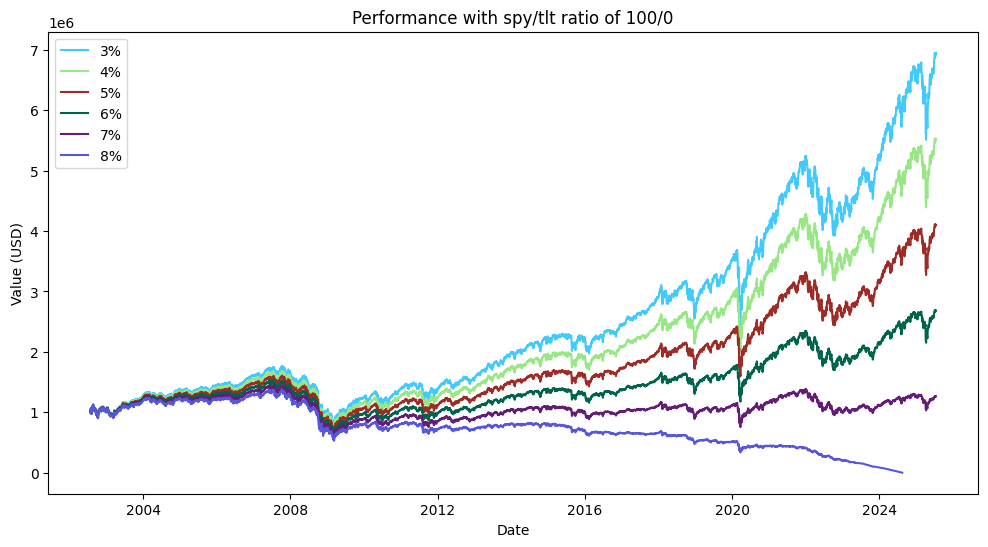

In [19]:
def plot_simulation(spy_ratio: float, withdrawal_rate: float, label, color):
    sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)
    value_over_time = sim1.simulate(1_000_000)

    # Unpack the data into two lists
    dates, values = zip(*value_over_time)

    plt.plot(dates, values, label=label, linestyle='-', color=color )

plt.figure(figsize=(12,6))
plot_simulation(1.0, 0.03, label='3%', color='#42CAFD')
plot_simulation(1.0, 0.04, label='4%', color='#97E884')
plot_simulation(1.0, 0.05, label='5%', color='#9E2B25')
plot_simulation(1.0, 0.06, label='6%', color='#00644C')
plot_simulation(1.0, 0.07, label='7%', color='#631D76')
plot_simulation(1.0, 0.08, label='8%', color='#5757DE')

plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 100/0')
plt.show()



The figures indicate the amount of money left for a period of 23 years for different withdrawal rates at spy/tlt ratio of 100/0. 
At 3% withdrawal rate, with a initial of 1 million dollars in 2002, you will have about 7 million dollars in 2025.
When you increase withdrawal rate (the more money you withdraw each day), the less money you have at the end of 23 years. 
At a 8% withdrawal rate, you will run out of money in 2024.

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_17804\130742287.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


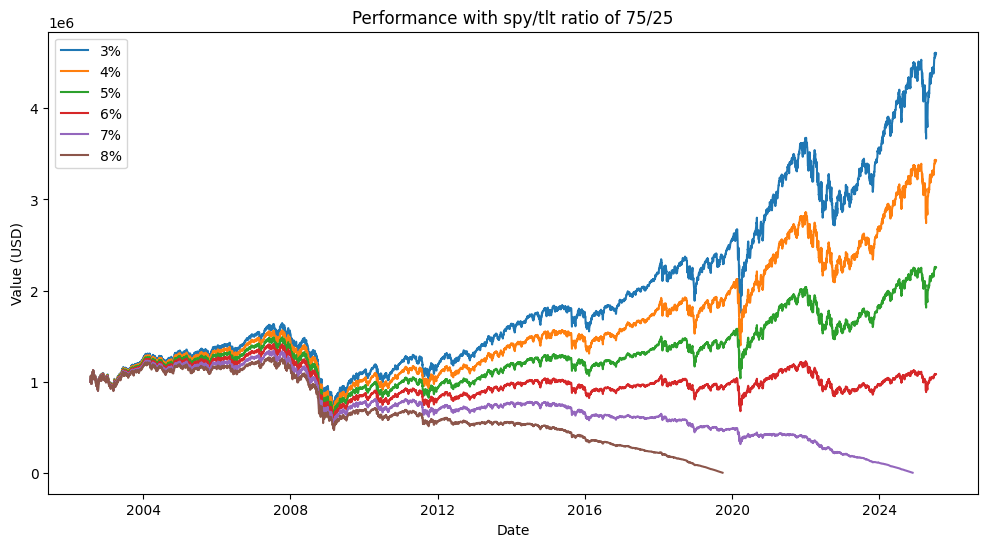

In [7]:
plt.figure(figsize=(12,6))
plot_simulation(0.75, 0.03, label='3%', color='#42CAFD')
plot_simulation(0.75, 0.04, label='4%', color='#97E884')
plot_simulation(0.75, 0.05, label='5%', color='#9E2B25')
plot_simulation(0.75, 0.06, label='6%', color='#00644C')
plot_simulation(0.75, 0.07, label='7%', color='#631D76')
plot_simulation(0.75, 0.08, label='8%', color='#5757DE')

plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 75/25')
plt.show()

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_17804\130742287.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


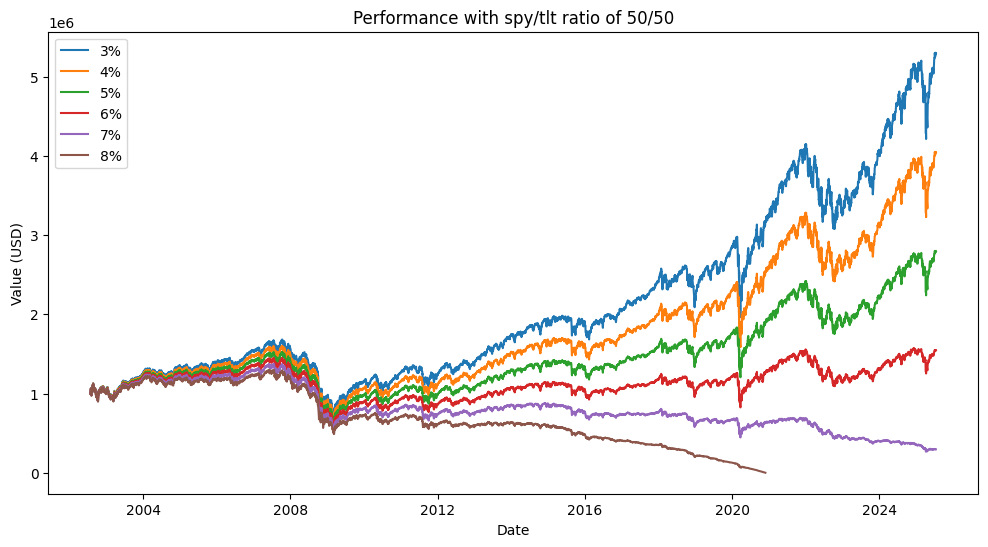

In [8]:
plt.figure(figsize=(12,6))
plot_simulation(0.5, 0.03, label='3%', color='#42CAFD')
plot_simulation(0.5, 0.04, label='4%', color='#97E884')
plot_simulation(0.5, 0.05, label='5%', color='#9E2B25')
plot_simulation(0.5, 0.06, label='6%', color='#00644C')
plot_simulation(0.5, 0.07, label='7%', color='#631D76')
plot_simulation(0.5, 0.08, label='8%', color='#5757DE')

plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 50/50')
plt.show()

C:\Users\xzzlo\AppData\Local\Temp\ipykernel_17804\130742287.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


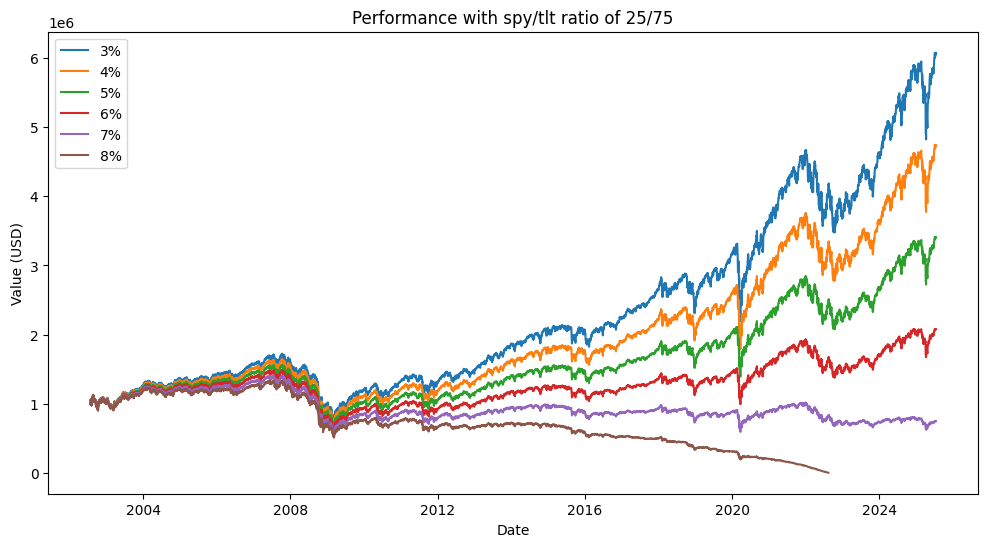

In [9]:
plt.figure(figsize=(12,6))
plot_simulation(0.25, 0.03, label='3%', color='#42CAFD')
plot_simulation(0.25, 0.04, label='4%', color='#97E884')
plot_simulation(0.25, 0.05, label='5%', color='#9E2B25')
plot_simulation(0.25, 0.06, label='6%', color='#00644C')
plot_simulation(0.25, 0.07, label='7%', color='#631D76')
plot_simulation(0.25, 0.08, label='8%', color='#5757DE')

plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 25/75')
plt.show()


C:\Users\xzzlo\AppData\Local\Temp\ipykernel_17804\130742287.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  sim1 = Simulate(Portfolio(SharesPrice(0.0, 0.0), SharesPrice(0.0, 0.0), spy_ratio, datetime.utcnow()), datetime(2002, 7, 26), timedelta(days=365.25*23), withdrawal_rate)


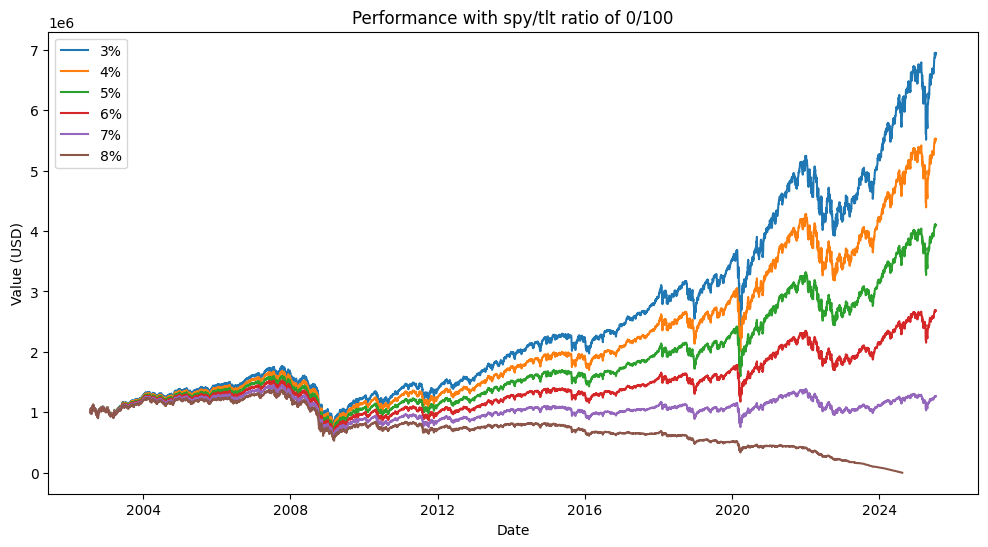

In [10]:
plt.figure(figsize=(12,6))
plot_simulation(0.0, 0.03, label='3%', color='#42CAFD')
plot_simulation(0.0, 0.04, label='4%', color='#97E884')
plot_simulation(0.0, 0.05, label='5%', color='#9E2B25')
plot_simulation(0.0, 0.06, label='6%', color='#00644C')
plot_simulation(0.0, 0.07, label='7%', color='#631D76')
plot_simulation(0.0, 0.08, label='8%', color='#5757DE')

plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.title(f'Performance with spy/tlt ratio of 0/100')
plt.show()